In [ ]:
import os, sys
import pandas as pd
from obspy.core import read, Stream
LIBpath = os.path.join( os.getenv('HOME'),'src','kitchensinkGT', 'LIB')
sys.path.append(LIBpath)
from libMVO import fix_trace_id, load_mvo_inventory
from metrics import process_trace, ampengfft
sys.path.append(os.path.join( os.getenv('HOME'),'src', 'icewebPy') )
import IceWeb

def metrics2df(st):
    tracedf = pd.DataFrame()
    list_of_tracerows = []
    for tr in st:
        s = tr.stats
        tracerow = {'id':tr.id, 'starttime':s.starttime, 
               'Fs':s.sampling_rate, 
               'calib':s.calib, 'units':s.units, 
               'quality':s.quality_factor}
        if 'spectrum' in s: 
            for item in ['medianF', 'peakF', 'peakA', 'bw_min', 'bw_max']:
                try:
                    tracerow[item] = s.spectrum[item]
                except:
                    pass
        if 'metrics' in s:
            m = s.metrics
            for item in ['snr', 'signal_level', 'noise_level', 'twin',
                         'peakamp', 'peaktime', 'energy', 'RSAM_high', 'RSAM_low',
                         'sample_min', 'sample_max', 'sample_mean', 'sample_median', 
                         'sample_lower_quartile', 'sample_upper_quartile', 'sample_rms', 
                         'sample_stdev', 'percent_availability', 'num_gaps', 'skewness', 'kurtosis']:
                         #'start_gap', 'num_gaps', 'end_gap', 'sum_gaps', 'max_gap', 
                         #'num_overlaps', 'sum_overlaps', 'num_records', 'record_length', 
                try:
                    tracerow[item] = m[item]
                except:
                    pass 
        if 'bandratio' in s:
            for dictitem in s['bandratio']:
                label = 'bandratio_' +  "".join(str(dictitem['freqlims'])).replace(', ','_')
                tracerow[label] = dictitem['RSAM_ratio']

        list_of_tracerows.append(tracerow)
    tracedf = pd.DataFrame(list_of_tracerows)
    tracedf = tracedf.round({'Fs': 2, 'secs': 2, 'quality':2, 'medianF':1, 'peakF':1, 'bw_max':1, 'bw_min':1, 'peaktime':2, 'twin':2, 'skewness':2, 'kurtosis':2})
    #tracedf.set_index('id')
    return tracedf

# bool_ASN: set True only if data are from MVO analog seismic network
def read_monty_wavfile_and_correct_traceIDs(wavpath, bool_ASN=False):
    if os.path.exists(wavpath):
        st = read(wavpath)
    else:
        print('ERROR. %s not found.' % wavpath)
        return Stream()
    fix_trace_id(st, shortperiod=bool_ASN) 
    return st

def enhance_stream(stream_in, CALDIR=None, quality_threshold=0.0):
    # if CALDIR provided, will try to correct traces
    st = stream_in.copy()
    for tr in st:
        this_inv = None            
        if CALDIR: # try to find corresponding station XML
            this_inv = load_mvo_inventory(tr, CALDIR)
            if tr.stats.channel[0:2]=='SN': # accelerometer channels
                tr.stats.calib = 27500000
                tr.data = tr.data / tr.stats.calib # approx calib from comparing with co-located differentiated LA100 waveforms
                tr.stats.units = 'm/s2'            
        process_trace(tr, inv=this_inv, quality_threshold=quality_threshold)
            
    # remove bad traces
    for tr in st:    
        if tr.stats.quality_factor <= quality_threshold:
            st.remove(tr)
            
    if CALDIR: # remove traces not corrected
        physical_units = ['m', 'm/s', 'm/s2', 'Pa']
        for tr in st:    
            if not tr.stats.units in physical_units:
                st.remove(tr)        
        
    # add AEF metrics        
    iwsobj = IceWeb.icewebSpectrogram(stream=st)
    iwsobj = iwsobj.precompute() # spectrograms data added
    iwsobj.compute_amplitude_spectrum(compute_bandwidth=True) # adds tr.stats.spectrum
    for tr in iwsobj.stream:
        ampengfft(tr) # add peaktime, peakamp, energy 
        tr.stats.pop('spectrogramdata', None) # Remove spectrogramdata as it is large
    enhanced_stream = iwsobj.stream 
    
    return enhanced_stream

def save_enhanced_stream(st, eventdf, enhanced_wavpath, save_pickle=False):
    # save Miniseed
    st.write(enhanced_wavpath + '.mseed', 'MSEED')
    
    # metrics dataframe
    eventdf = metrics2df(st)
    eventdf.to_csv(enhanced_wavpath + '.csv',index=False)
        
    # write to pickle file?
    if save_pickle:
        st.write(enhanced_wavpath + '.pickle', 'PICKLE') # Rewrite pickle file with extra attributes     
    

21 Trace(s) in Stream:

MV.MBGA..BHZ | 1996-10-24T06:41:25.040000Z - 1996-10-24T06:42:22.880138Z | 75.2 Hz, 4350 samples
...
(19 other traces)
...
MV.MBGB..BHE | 1996-10-24T06:41:25.040000Z - 1996-10-24T06:42:22.880138Z | 75.2 Hz, 4350 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]
21 Trace(s) in Stream:

MV.MBGA..BHZ | 1996-10-24T06:41:25.040000Z - 1996-10-24T06:42:22.880138Z | 75.2 Hz, 4350 samples
...
(19 other traces)
...
MV.MBGB..BHE | 1996-10-24T06:41:25.040000Z - 1996-10-24T06:42:22.880138Z | 75.2 Hz, 4350 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]
MV.MBWH..SHZ 0 k 0.25
MV.MBWH..SNZ 0 k 0.25
MV.MBRY..SHZ 0 k 0.25
MV.MBRY..SNZ 0 k 0.25
MV.MBGA..BHZ 0 k 0.25
MV.MBGA..BHN 1 g 0.1
MV.MBGA..BHE 2 r 0.1
MV.MBGB..BHZ 0 k 0.25
MV.MBGB..BHN 1 g 0.1
MV.MBGB..BHE 2 r 0.1
MV.MBGE..BHZ 0 k 0.25
MV.MBGE..BHN 1 g 0.1
MV.MBGE..BHE 2 r 0.1
MV.MBGH..BHZ 0 k 0.25
MV.MBGH..BHN 1 g 0.1
MV.MBGH..BHE 2 r 0.1
MV.MBBE..BHZ 0 k 0.25
MV.MBBE..BHN 1

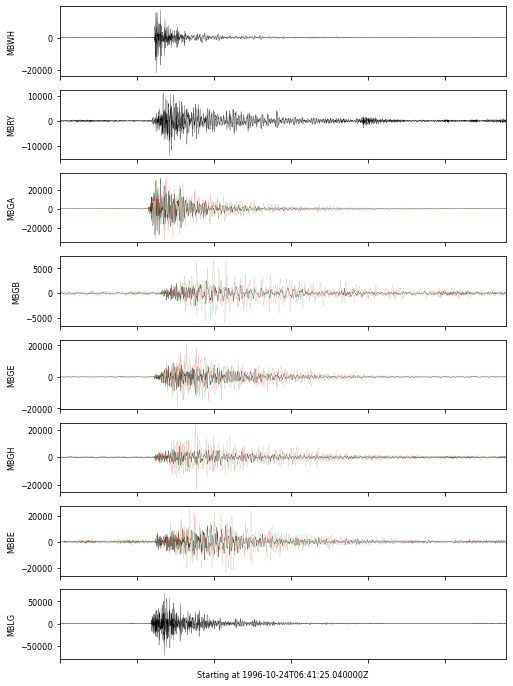

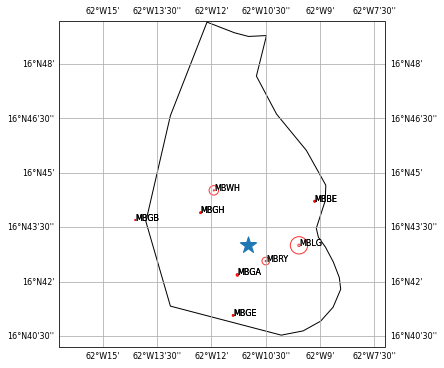

MV.MBWH..SHZ 0 k 0.25
MV.MBWH..SNZ 0 k 0.25
MV.MBRY..SHZ 0 k 0.25
MV.MBRY..SNZ 0 k 0.25
MV.MBGA..BHZ 0 k 0.25
MV.MBGA..BHN 1 g 0.1
MV.MBGA..BHE 2 r 0.1
MV.MBGB..BHZ 0 k 0.25
MV.MBGB..BHN 1 g 0.1
MV.MBGB..BHE 2 r 0.1
MV.MBGE..BHZ 0 k 0.25
MV.MBGE..BHN 1 g 0.1
MV.MBGE..BHE 2 r 0.1
MV.MBGH..BHZ 0 k 0.25
MV.MBGH..BHN 1 g 0.1
MV.MBGH..BHE 2 r 0.1
MV.MBBE..BHZ 0 k 0.25
MV.MBBE..BHN 1 g 0.1
MV.MBBE..BHE 2 r 0.1
MV.MBLG..SHZ 0 k 0.25
MV.MBLG..SNZ 0 k 0.25


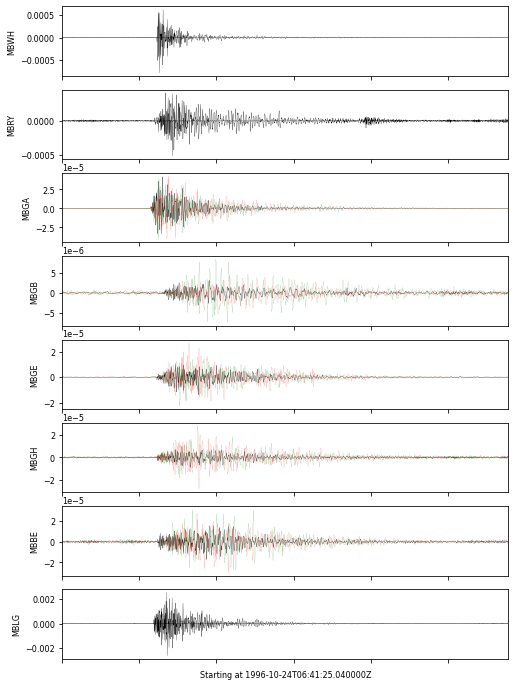

In [33]:
# workflow for processing a single WAV file and making plots
from libMVO import plot_station_amplitude_map
from libseisGT import plot_seismograms

SEISAN_DATA = os.path.join( os.getenv('HOME'),'DATA','MVO') # e.g. /home/user/seismo
SEISAN_DB = 'MVOE_'
station0hypfile = os.path.join(SEISAN_DATA, 'DAT', 'STATION0_MVO.HYP')

wavpath = os.path.join(SEISAN_DATA, 'WAV', SEISAN_DB, '1996/10/9610-24-0641-25S.MVO_21_1')
wavbase = os.path.basename(wavpath)
CALDIR = os.path.join(SEISAN_DATA, 'CAL')

raw_st = read_monty_wavfile_and_correct_traceIDs(wavpath, bool_ASN=False)
print(raw_st)

uncorrected_st = enhance_stream(raw_st)
print(uncorrected_st)
uncorrected_df = metrics2df(uncorrected_st)
save_enhanced_stream(uncorrected_st, uncorrected_df, wavbase + '.uncorrected', save_pickle=True)
plot_seismograms(uncorrected_st, outfile='uncorrected_seismograms.png')

corrected_st = enhance_stream(raw_st, CALDIR)
corrected_df = metrics2df(corrected_st)
print(corrected_st)
save_enhanced_stream(corrected_st, corrected_df, wavbase + '.corrected', save_pickle=True)
plot_station_amplitude_map(corrected_st, station0hypfile=station0hypfile)
plot_seismograms(corrected_st, outfile='corrected_seismograms.png')

In [32]:
# Workflow for checking I can reconstruct from MiniSEED and CSV file

def read_enhanced_stream(enhanced_wavpath):
    
    # read Miniseed
    st = read(enhanced_wavpath + '.mseed', 'MSEED')
    
    # read metrics dataframe
    eventdf = pd.read_csv(enhanced_wavpath + '.csv', index_col=False)

    for tr in st:
        s = tr.stats
        row = eventdf[eventdf.id==tr.id].iloc[0].to_dict()
        s.units = row['units']
        s.calib = row['calib']
        s['quality_factor'] = row['quality']
        s['spectrum'] = {}
        for item in ['medianF', 'peakF', 'peakA', 'bw_min', 'bw_max']:
            try:
                s.spectrum[item] = row[item]
            except:
                pass
        s['metrics']={}
        for item in ['snr', 'signal_level', 'noise_level', 'twin',
                     'peakamp', 'peaktime', 'energy', 'RSAM_high', 'RSAM_low',
                     'sample_min', 'sample_max', 'sample_mean', 'sample_median', 
                     'sample_lower_quartile', 'sample_upper_quartile', 'sample_rms', 
                     'sample_stdev', 'percent_availability', 'num_gaps', 'skewness', 'kurtosis']:
            try:
                s.metrics[item] = row[item]
            except:
                pass 
        s['bandratio']=[{'freqlims': [1.0, 6.0, 11.0], 'RSAM_ratio': row['bandratio_[1.0_6.0_11.0]']}, 
                        {'freqlims': [0.8, 4.0, 16.0], 'RSAM_ratio': row['bandratio_[0.8_4.0_16.0]']}]
    
    return st


corrected_st2 = read_enhanced_stream(wavbase + '.corrected')
print(corrected_st2)
corrected_df2 = metrics2df(corrected_st2)
save_enhanced_stream(corrected_st2, corrected_df2, wavbase + 'corrected2', save_pickle=True)

21 Trace(s) in Stream:

MV.MBGA..BHZ | 1996-10-24T06:41:25.040000Z - 1996-10-24T06:42:22.880138Z | 75.2 Hz, 4350 samples
...
(19 other traces)
...
MV.MBGB..BHE | 1996-10-24T06:41:25.040000Z - 1996-10-24T06:42:22.880138Z | 75.2 Hz, 4350 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]


calibs= [808880064.01227438, 808880064.01227438, 808880064.01227438, 461997556.10772753, 27500000, 461997556.10772753, 27500000, 808880064.01227438, 808880064.01227438, 808880064.01227438, 808880064.01227438, 808880064.01227438, 808880064.01227438, 461997556.10772753, 27500000, 808880064.01227438, 808880064.01227438, 808880064.01227438, 808880064.01227438, 808880064.01227438, 808880064.01227438]


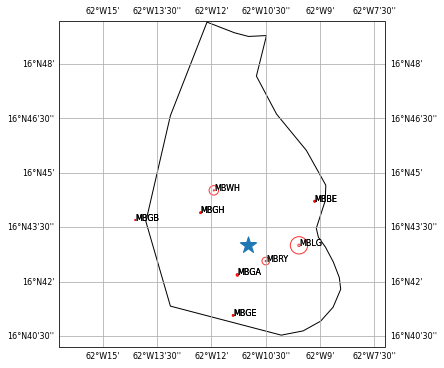

MV.MBWH..SHZ 0 k 0.25
MV.MBWH..SNZ 0 k 0.25
MV.MBRY..SHZ 0 k 0.25
MV.MBRY..SNZ 0 k 0.25
MV.MBGA..BHZ 0 k 0.25
MV.MBGA..BHN 1 g 0.1
MV.MBGA..BHE 2 r 0.1
MV.MBGB..BHZ 0 k 0.25
MV.MBGB..BHN 1 g 0.1
MV.MBGB..BHE 2 r 0.1
MV.MBGE..BHZ 0 k 0.25
MV.MBGE..BHN 1 g 0.1
MV.MBGE..BHE 2 r 0.1
MV.MBGH..BHZ 0 k 0.25
MV.MBGH..BHN 1 g 0.1
MV.MBGH..BHE 2 r 0.1
MV.MBBE..BHZ 0 k 0.25
MV.MBBE..BHN 1 g 0.1
MV.MBBE..BHE 2 r 0.1
MV.MBLG..SHZ 0 k 0.25
MV.MBLG..SNZ 0 k 0.25


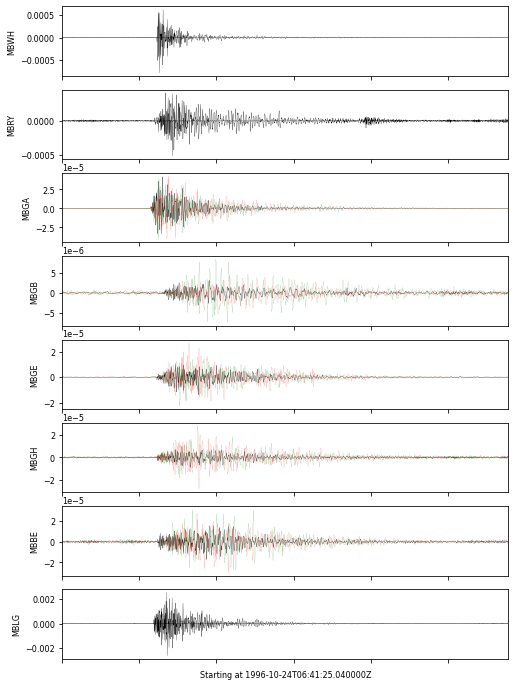

In [31]:
from libMVO import plot_station_amplitude_map
from libseisGT import plot_seismograms
station0hypfile = os.path.join(SEISAN_DATA, 'DAT', 'STATION0_MVO.HYP')
plot_station_amplitude_map(corrected_st, station0hypfile=station0hypfile)
plot_seismograms(corrected_st)